# Intestinal organoid differentiation - Palantir

Construct palantir pseudotime on scEU-seq organoid data.

## Library imports

In [1]:
import os
import sys

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import palantir
import scanpy as sc
import scvelo as scv

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3

In [3]:
# Inline plotting
%matplotlib inline

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

In [4]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [5]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [6]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled'
    obsp: 'connectivities', 'distances'

## Data preprocessing

In [7]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

celltype_to_color = dict(zip(adata.obs["cell_type"].cat.categories, adata.uns["cell_type_colors"]))
adata.uns["cell_type_merged_colors"] = list(
    {cell_type: celltype_to_color[cell_type] for cell_type in adata.obs["cell_type_merged"].cat.categories}.values()
)

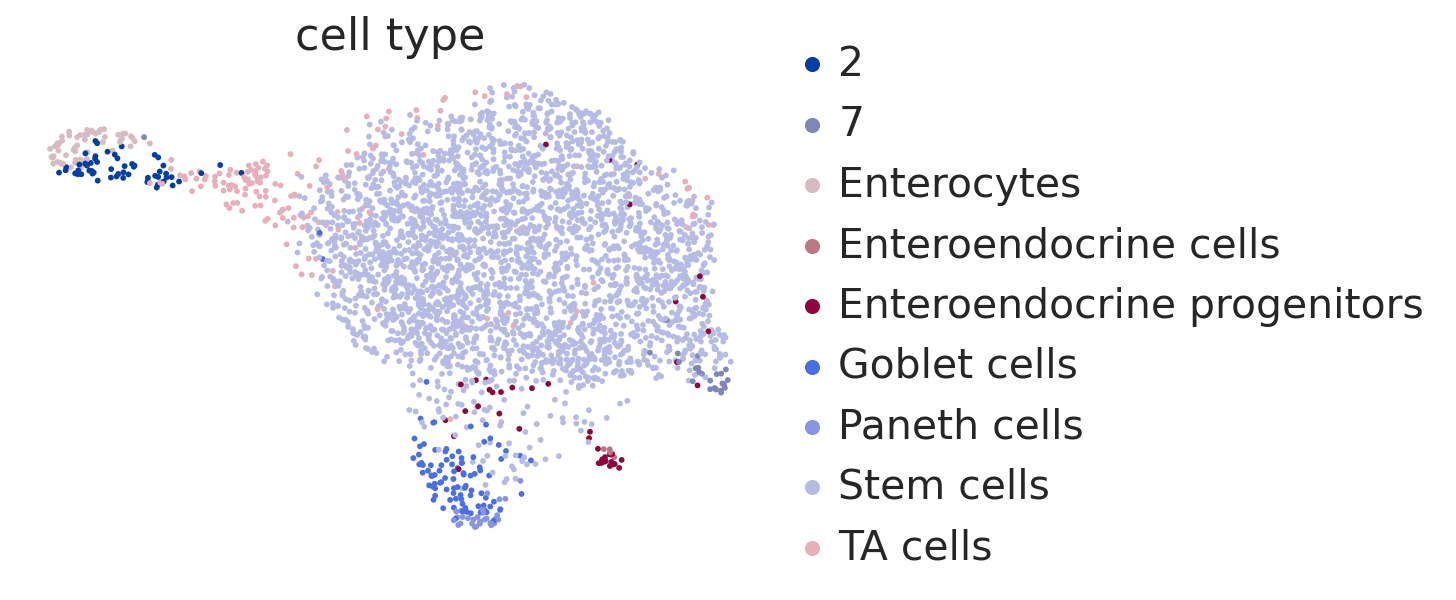

In [8]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

### Palantir pseudotime

In [9]:
pc_projection = pd.DataFrame(adata.obsm["X_pca"].copy(), index=adata.obs_names)

# diffusion maps
diff_maps = palantir.utils.run_diffusion_maps(pc_projection, n_components=5)

# multiscale space
multiscale_space = palantir.utils.determine_multiscale_space(diff_maps)

Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [10]:
root_idx = 2899  # See DPT notebook
palantir_res = palantir.core.run_palantir(
    multiscale_space, adata.obs_names[root_idx], use_early_cell_as_start=True, num_waypoints=500
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.002442185084025065 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back t

Time for shortest paths: 0.09969128767649332 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [11]:
adata.obs["palantir_pseudotime"] = palantir_res.pseudotime

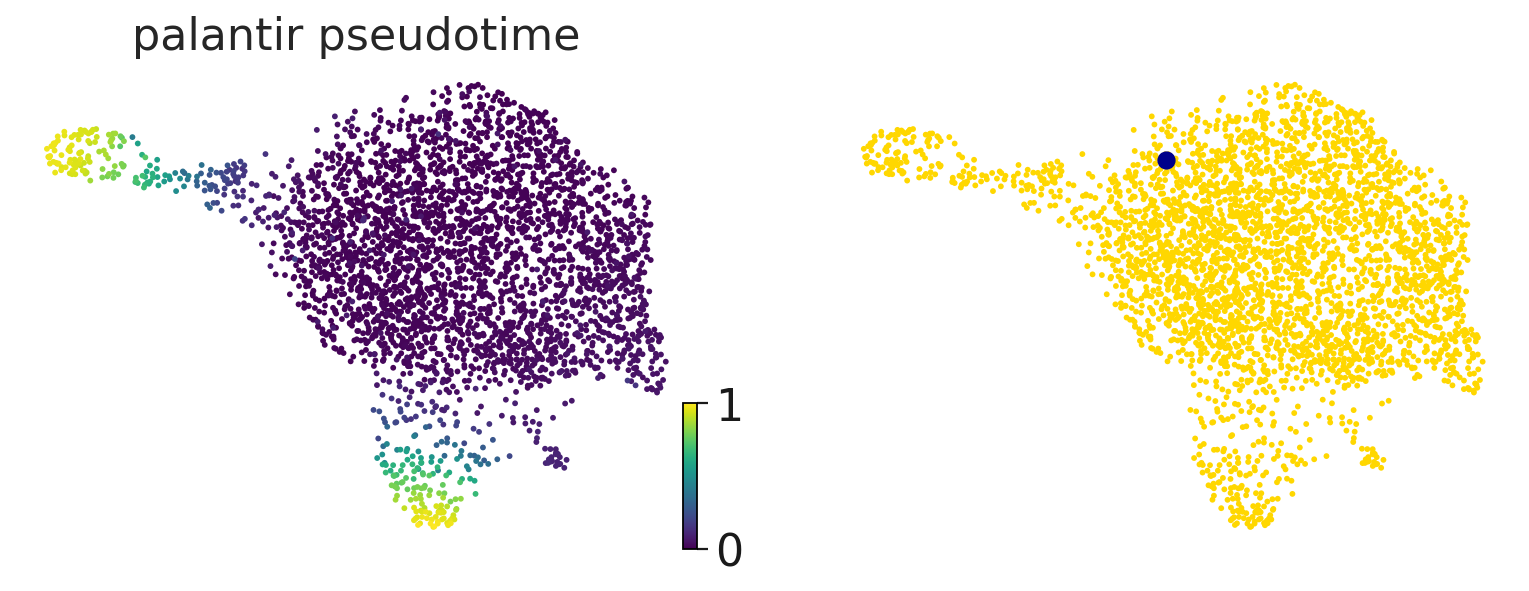

In [12]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color=["palantir_pseudotime", root_idx], color_map="viridis")

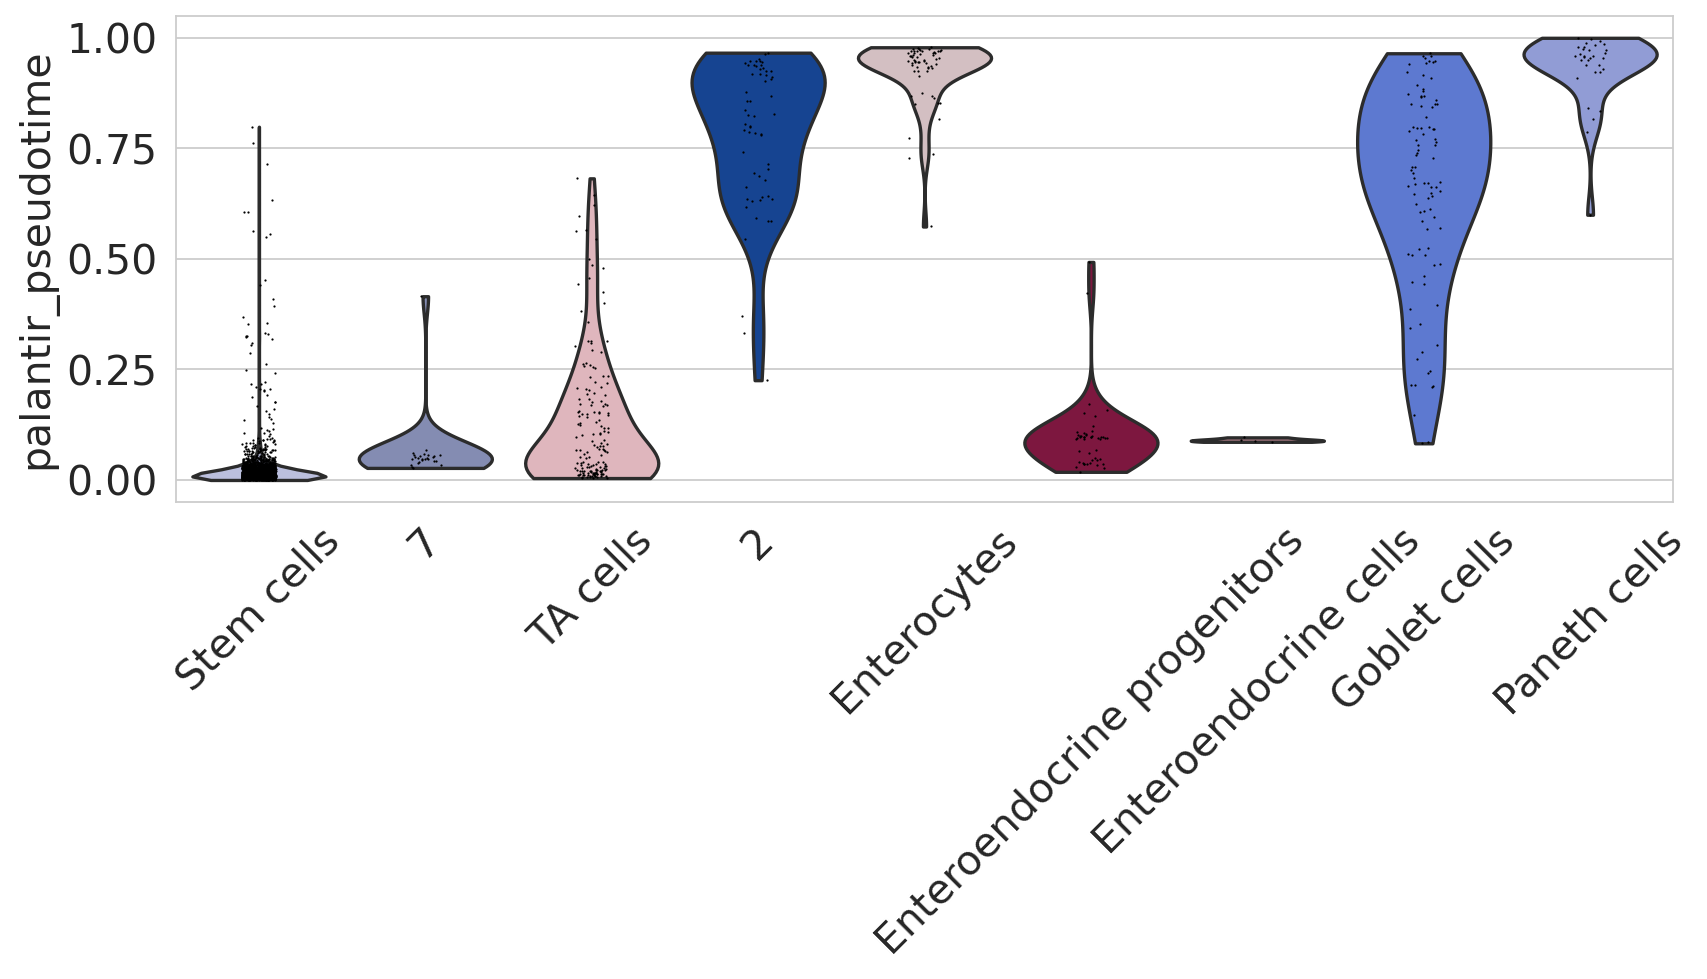

In [13]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["palantir_pseudotime"],
        groupby="cell_type",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Enteroendocrine cells",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "palantir_vs_cell_type.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

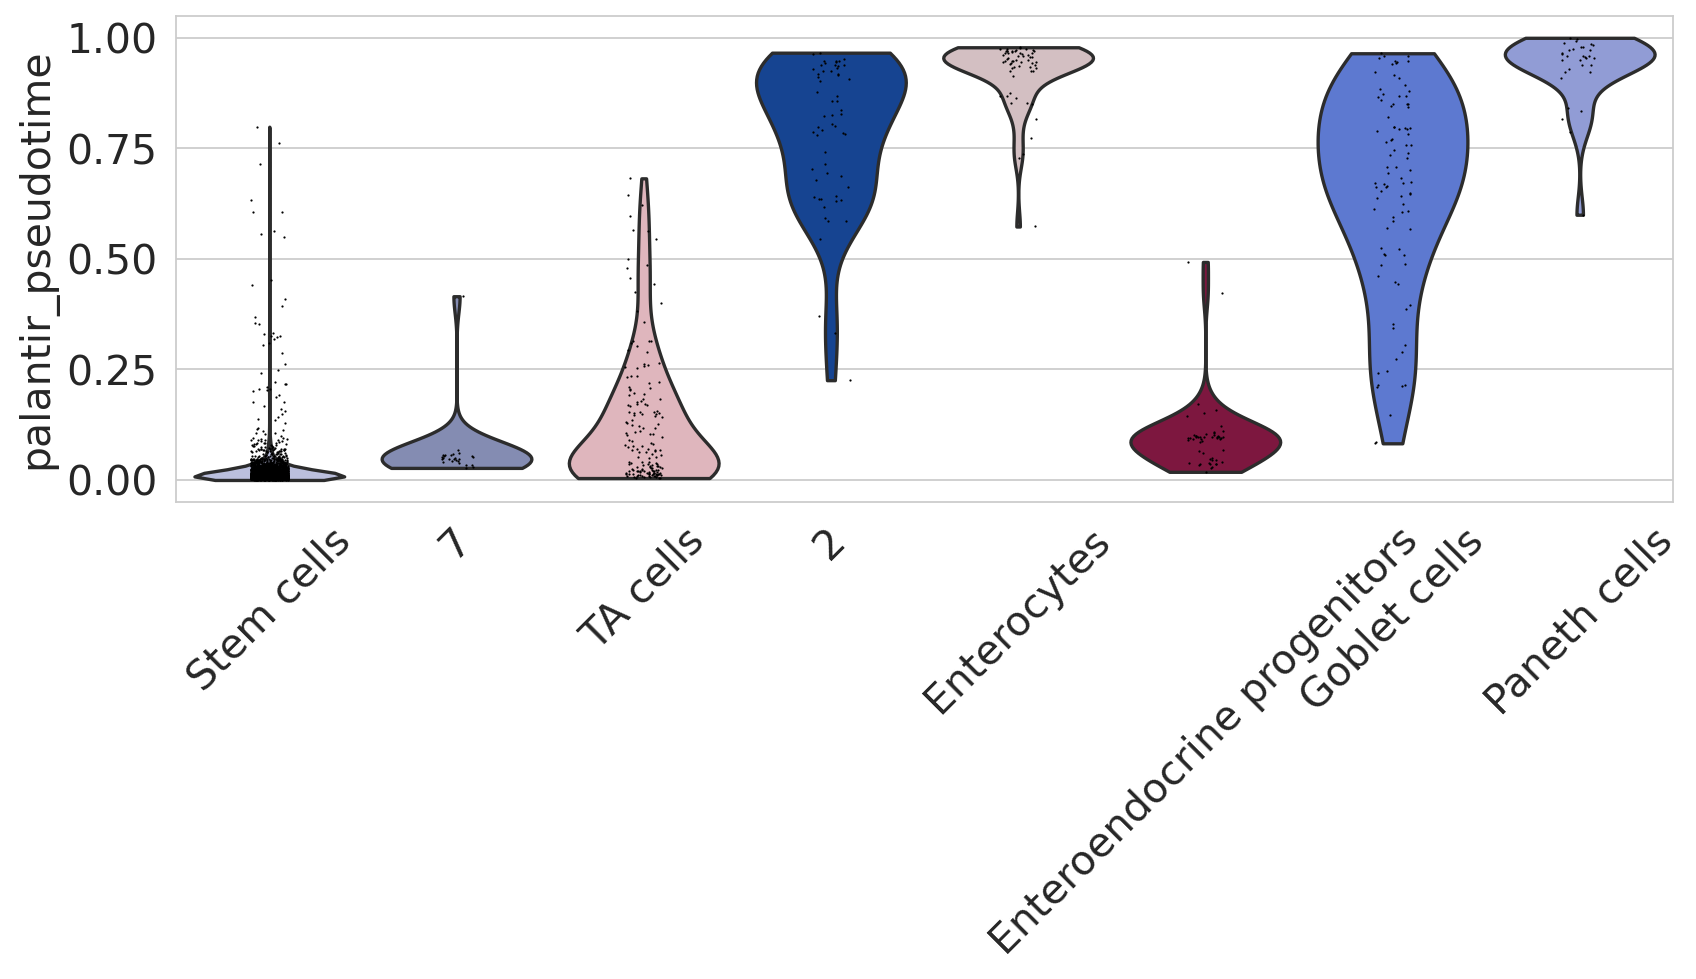

In [14]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["palantir_pseudotime"],
        groupby="cell_type_merged",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "palantir_vs_cell_type_merged.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

In [15]:
adata.obs["palantir_pseudotime"].to_csv(DATA_DIR / "sceu_organoid" / "results" / "palantir.csv")